Datasets used: 
- `Law School Success` :<br>
The dataset was originally collected for a study called 'LSAC National Longitudinal Bar Passage Study'. It includes background information and if (and how) candidates passed the bar exam to become lawyers/legal practicioners in the USA<br>

    Important Variables:
    
    gender: Gender of the student.<br>
    lsat: LSAT score received by the student.<br>
    pass_bar: Ground truth label indicating whether or not the student eventually passed the bar.<br>
    race: Race of the student.<br>
    gpa: A student's undergraduate GPA.<br>

Reference Links: https://www.kaggle.com/datasets/danofer/law-school-admissions-bar-passage?resource=download

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gfacts
from gfacts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from gfacts.models import customLogisticRegression
from gfacts.parameters import ParameterProxy
from gfacts.formatting import recourse_report_reverse, print_recourse_report
from aif360.sklearn.datasets import fetch_adult
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

In [2]:
sensitive_attribute = "race1"

## Load Dataset

In [3]:
DATAFILE= "bar_pass_prediction.csv"

#learning_class_weights = {0: 50, 1: 5}

X = pd.read_csv(DATAFILE)
#Drop unnecessary features
X = X.drop(columns=['sex','dnn_bar_pass_prediction','ID','bar_passed','race',
                    'race2','decile1b','decile3','decile1','asian','black','hisp','other','index6040','bar1','bar2','DOB_yr','male','bar','indxgrp','indxgrp2','grad'
                    ,'bar1_yr','bar2_yr','parttime','age','cluster','zgpa','fulltime','fam_inc','Dropout','tier','gpa','pass_bar'])
num_features = X._get_numeric_data().columns.to_list()

df = X.copy()
cate_features = df.select_dtypes(include=['object']).columns.to_list()
df = df.dropna()
df = df.reset_index(drop=True)

df.head()

,lsat,ugpa,zfygpa,gender,race1
0,44.0,3.5,1.33,female,white
1,29.0,3.5,-0.11,female,white
2,36.0,3.5,-0.64,male,white
3,39.0,3.5,0.34,male,white
4,48.0,3.5,1.02,male,white


In [4]:
df.zfygpa = np.where(df.zfygpa >= df.zfygpa.median(),1,0)

In [5]:
indexRace = df[ (df['race1'] != 'black') & (df['race1'] != 'white') ].index
df.drop(indexRace , inplace=True)

In [6]:
df.head()

,lsat,ugpa,zfygpa,gender,race1
0,44.0,3.5,1,female,white
1,29.0,3.5,0,female,white
2,36.0,3.5,0,male,white
3,39.0,3.5,1,male,white
4,48.0,3.5,1,male,white


## Model training and test

In [7]:
X = df.drop('zfygpa', axis=1)
y = df['zfygpa']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [8]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='labels')
model.predict(X_test.iloc[:100, :])

Wall time: 190 ms


array([1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0.])

In [9]:
positive_label = 1
negative_label = 0
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       0.62      0.45      0.52      2754
           1       0.60      0.74      0.66      3006

    accuracy                           0.60      5760
   macro avg       0.61      0.60      0.59      5760
weighted avg       0.60      0.60      0.59      5760



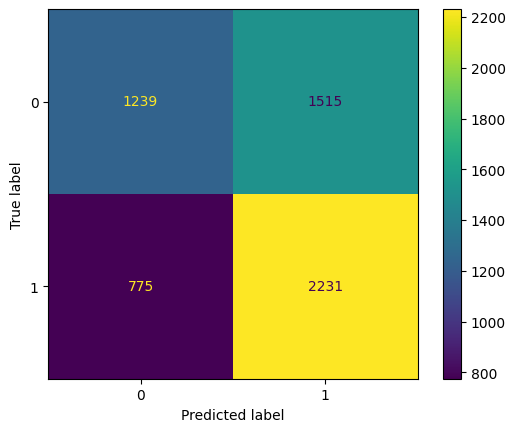

In [10]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [11]:
for col in cate_features:
    X_test[col] = X_test[col].astype('object')

In [12]:
ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
     X_test,
     model=model,
     sensitive_attribute='race1',
     missing_subgroup_val="Unknown"
 )

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|██████████| 2/2 [00:00<00:00, 34.97it/s]

Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|██████████| 2/2 [00:00<00:00, 738.56it/s]

Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.



100%|██████████| 76/76 [00:00<00:00, 4160.42it/s]

Computing correctenesses for all valid if-thens.



100%|██████████| 947/947 [00:11<00:00, 81.19it/s] 

Number of if-thens: 947


In [ ]:
#### Uncomment if you wish to load rules object from disk

import dill

with open("rulesLawSchool.data", "rb") as inf:
    rules_by_if = dill.load(inf)

In [13]:
#### Uncomment if you wish to save rules object on disk

import dill

with open("rulesLawSchool.data", "wb") as outf:
     dill.dump(rules_by_if, outf)

In [13]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["white"][1][0][1]-e[1]["black"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If lsat = 37.0, gender = female:
	Subgroup 'black', 1.79% covered
		Make lsat = 41.0 with correctness 0.00%.
		Make lsat = 42.0 with correctness 0.00%.
		Make lsat = 35.0 with correctness 0.00%.
		Make lsat = 45.0 with correctness 0.00%.
		Make lsat = 34.0 with correctness 0.00%.
	Subgroup 'white', 1.73% covered
		Make lsat = 41.0 with correctness 100.00%.
		Make lsat = 42.0 with correctness 100.00%.
		Make lsat = 35.0 with correctness -0.00%.
		Make lsat = 45.0 with correctness 100.00%.
		Make lsat = 34.0 with correctness -0.00%.
If gender = male, lsat = 27.0:
	Subgroup 'black', 1.28% covered
		Make lsat = 39.0 with correctness 0.00%.
		Make lsat = 40.0 with correctness 0.00%.
		Make lsat = 42.0 with correctness 0.00%.
		Make lsat = 38.0 with correctness 0.00%.
		Make lsat = 37.0 with correctness 0.00%.
		Make lsat = 36.0 with correctness 0.00%.
		Make lsat = 41.0 with correctness 0.00%.
		Make gender = female, lsat = 39.0 with correctness 0.00%.
		Make gender = female, lsat = 40.0 wi

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [14]:
feature_weights = {"gender": 1, "race1": 1}
comparators = gfacts.naive_feature_change_builder(num_cols=num_features, cate_cols=cate_features, feature_weights=feature_weights)
params = ParameterProxy(featureChanges=comparators)

## Weighted Average Score

In [15]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 10
)

pop_sizes = {sg: (X["race1"] == sg).sum() for sg in X["race1"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If lsat = 28.0, gender = male:
	Subgroup 'black', 2.81% covered out of 1279
		Make lsat = 37.0, gender = female with correctness 0.00%.
		Make lsat = 41.0, gender = female with correctness 0.00%.
		Make lsat = 42.0, gender = female with correctness 0.00%.
		Make lsat = 35.0, gender = female with correctness 0.00%.
		Make lsat = 45.0, gender = female with correctness 0.00%.
		Make lsat = 34.0, gender = female with correctness 0.00%.
		Aggregate cost of the above recourses = -0e+00
	Subgroup 'white', 1.91% covered out of 17921
		Make lsat = 37.0, gender = female with correctness 80.65%.
		Make lsat = 41.0, gender = female with correctness 100.00%.
		Make lsat = 42.0, gender = female with correctness 100.00%.
		Make lsat = 35.0, gender = female with correctness 38.71%.
		Make lsat = 45.0, gender = female with correctness 100.00%.
		Make lsat = 34.0, gender = female with correctness 9.68%.
		Aggregate cost of the above recourses = -1e+00
	Bias against black. Unfairness measure = 1.43.
If g

## Minimum cost above threshold

In [16]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"],
    secondary_sorting=True
)

pop_sizes = {sg: (X["race1"] == sg).sum() for sg in X["race1"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If lsat = 32.0:
	Subgroup 'black', 9.95% covered out of 1279
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'white', 9.74% covered out of 17921
		Make lsat = 39.0 with correctness 94.30%.
		Make lsat = 40.0 with correctness 96.84%.
		Make lsat = 38.0 with correctness 93.67%.
		Make lsat = 42.0 with correctness 99.37%.
		Make lsat = 37.0 with correctness 82.28%.
		Make lsat = 41.0 with correctness 98.10%.
		Make lsat = 36.0 with correctness 67.09%.
		Make lsat = 44.0 with correctness 100.00%.
		Make lsat = 35.0 with correctness 51.27%.
		Make lsat = 43.0 with correctness 99.37%.
		Make lsat = 45.0 with correctness 100.00%.
		Make lsat = 46.0 with correctness 100.00%.
		Make lsat = 47.0 with correctness 100.00%.
		Make lsat = 48.0 with correctness 100.00%.
		Aggregate cost of the above recourses = 1e+00
	Bias against black. Unfairness measure = inf.
If ugpa = 3.0:
	Subgroup 'black', 9.95% covered out of 1279
		No recourses for this subgroup!
		A

## Mean cost above threshold

In [17]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="mean-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"]
)

pop_sizes = {sg: (X["race1"] == sg).sum() for sg in X["race1"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If lsat = 32.0:
	Subgroup 'black', 9.95% covered out of 1279
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'white', 9.74% covered out of 17921
		Make lsat = 39.0 with correctness 94.30%.
		Make lsat = 40.0 with correctness 96.84%.
		Make lsat = 38.0 with correctness 93.67%.
		Make lsat = 42.0 with correctness 99.37%.
		Make lsat = 37.0 with correctness 82.28%.
		Make lsat = 41.0 with correctness 98.10%.
		Make lsat = 36.0 with correctness 67.09%.
		Make lsat = 44.0 with correctness 100.00%.
		Make lsat = 35.0 with correctness 51.27%.
		Make lsat = 43.0 with correctness 99.37%.
		Make lsat = 45.0 with correctness 100.00%.
		Make lsat = 46.0 with correctness 100.00%.
		Make lsat = 47.0 with correctness 100.00%.
		Make lsat = 48.0 with correctness 100.00%.
		Aggregate cost of the above recourses = 1e+00
	Bias against black. Unfairness measure = inf.
If ugpa = 3.0:
	Subgroup 'black', 9.95% covered out of 1279
		No recourses for this subgroup!
		A

## Number above threshold

In [18]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (X["race1"] == sg).sum() for sg in X["race1"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If gender = male, lsat = 29.0:
	Subgroup 'black', 1.79% covered out of 1279
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0e+00
	Subgroup 'white', 2.16% covered out of 17921
		Make lsat = 39.0 with correctness 97.14%.
		Make lsat = 40.0 with correctness 100.00%.
		Make lsat = 42.0 with correctness 100.00%.
		Make lsat = 38.0 with correctness 94.29%.
		Make lsat = 37.0 with correctness 94.29%.
		Make lsat = 36.0 with correctness 91.43%.
		Make lsat = 41.0 with correctness 100.00%.
		Make gender = female, lsat = 39.0 with correctness 94.29%.
		Make gender = female, lsat = 40.0 with correctness 97.14%.
		Make gender = female, lsat = 38.0 with correctness 94.29%.
		Make lsat = 44.0 with correctness 100.00%.
		Make lsat = 35.0 with correctness 80.00%.
		Make lsat = 43.0 with correctness 100.00%.
		Make lsat = 45.0 with correctness 100.00%.
		Make gender = female, lsat = 36.0 with correctness 74.29%.
		Make gender = female, lsat = 43.0 with correctness 100.00%.


# Aggregate correctness of rules and cost correctness plots

Load state from disk, if you wish.

In [20]:
import dill

with open("stateLawSchool.data", "rb") as inf:
    rules_by_if, model, X_test = dill.load(inf)

Trying to unpickle estimator LogisticRegression from version 1.1.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator OneHotEncoder from version 1.1.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator LabelEncoder from version 1.1.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


If lsat = 28.0, gender = male:
	Subgroup 'black', 2.81% covered out of 1279
		Make lsat = 37.0, gender = female with correctness 0.00%.
		Make lsat = 41.0, gender = female with correctness 0.00%.
		Make lsat = 42.0, gender = female with correctness 0.00%.
		Make lsat = 35.0, gender = female with correctness 0.00%.
		Make lsat = 45.0, gender = female with correctness 0.00%.
		Make lsat = 34.0, gender = female with correctness 0.00%.
	Subgroup 'white', 1.91% covered out of 17921
		Make lsat = 37.0, gender = female with correctness 80.65%.
		Make lsat = 41.0, gender = female with correctness 100.00%.
		Make lsat = 42.0, gender = female with correctness 100.00%.
		Make lsat = 35.0, gender = female with correctness 38.71%.
		Make lsat = 45.0, gender = female with correctness 100.00%.
		Make lsat = 34.0, gender = female with correctness 9.68%.
	Bias against black. Unfairness measure = 1.43.
	Cumulative correctness plot for the above recourses:


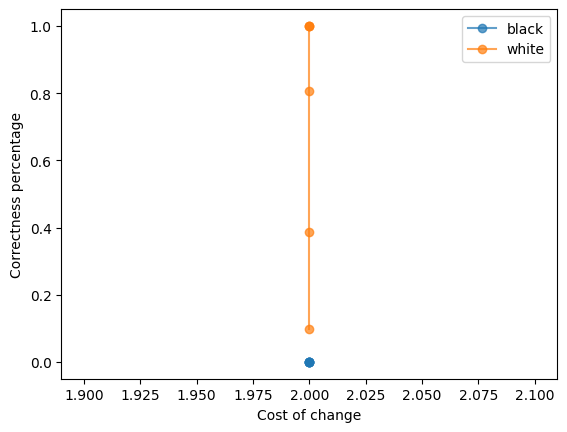

If gender = female, lsat = 36.0:
	Subgroup 'black', 2.04% covered out of 1279
		Make gender = male, lsat = 39.0 with correctness -0.00%.
		Make gender = male, lsat = 40.0 with correctness -0.00%.
		Make gender = male, lsat = 42.0 with correctness -0.00%.
		Make gender = male, lsat = 38.0 with correctness -0.00%.
		Make gender = male, lsat = 37.0 with correctness -0.00%.
		Make gender = male with correctness -0.00%.
		Make gender = male, lsat = 41.0 with correctness -0.00%.
		Make lsat = 39.0 with correctness -0.00%.
		Make lsat = 40.0 with correctness -0.00%.
		Make lsat = 38.0 with correctness -0.00%.
		Make gender = male, lsat = 44.0 with correctness -0.00%.
		Make gender = male, lsat = 35.0 with correctness -0.00%.
		Make gender = male, lsat = 43.0 with correctness -0.00%.
		Make gender = male, lsat = 45.0 with correctness -0.00%.
		Make lsat = 43.0 with correctness -0.00%.
		Make lsat = 44.0 with correctness -0.00%.
		Make gender = male, lsat = 46.0 with correctness -0.00%.
		Make 

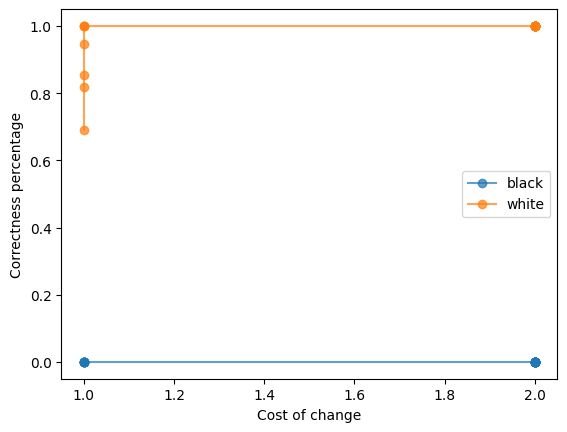

If lsat = 31.0, gender = male:
	Subgroup 'black', 2.30% covered out of 1279
		Make lsat = 37.0, gender = female with correctness 0.00%.
		Make lsat = 41.0, gender = female with correctness 0.00%.
		Make lsat = 42.0, gender = female with correctness 0.00%.
		Make lsat = 35.0, gender = female with correctness 0.00%.
		Make lsat = 45.0, gender = female with correctness 0.00%.
		Make lsat = 34.0, gender = female with correctness 0.00%.
	Subgroup 'white', 4.19% covered out of 17921
		Make lsat = 37.0, gender = female with correctness 58.82%.
		Make lsat = 41.0, gender = female with correctness 95.59%.
		Make lsat = 42.0, gender = female with correctness 98.53%.
		Make lsat = 35.0, gender = female with correctness 32.35%.
		Make lsat = 45.0, gender = female with correctness 100.00%.
		Make lsat = 34.0, gender = female with correctness 17.65%.
	Bias against black. Unfairness measure = 1.34.
	Cumulative correctness plot for the above recourses:


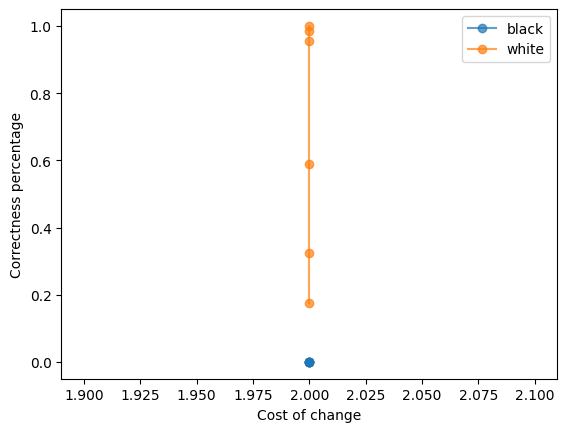

If gender = male, lsat = 29.0:
	Subgroup 'black', 1.79% covered out of 1279
		Make lsat = 39.0 with correctness 0.00%.
		Make lsat = 40.0 with correctness 0.00%.
		Make lsat = 42.0 with correctness 0.00%.
		Make lsat = 38.0 with correctness 0.00%.
		Make lsat = 37.0 with correctness 0.00%.
		Make lsat = 36.0 with correctness 0.00%.
		Make lsat = 41.0 with correctness 0.00%.
		Make gender = female, lsat = 39.0 with correctness 0.00%.
		Make gender = female, lsat = 40.0 with correctness 0.00%.
		Make gender = female, lsat = 38.0 with correctness 0.00%.
		Make lsat = 44.0 with correctness 0.00%.
		Make lsat = 35.0 with correctness 0.00%.
		Make lsat = 43.0 with correctness 0.00%.
		Make lsat = 45.0 with correctness 0.00%.
		Make gender = female, lsat = 36.0 with correctness 0.00%.
		Make gender = female, lsat = 43.0 with correctness 0.00%.
		Make gender = female, lsat = 44.0 with correctness 0.00%.
		Make lsat = 46.0 with correctness 0.00%.
		Make lsat = 47.0 with correctness 0.00%.
		Mak

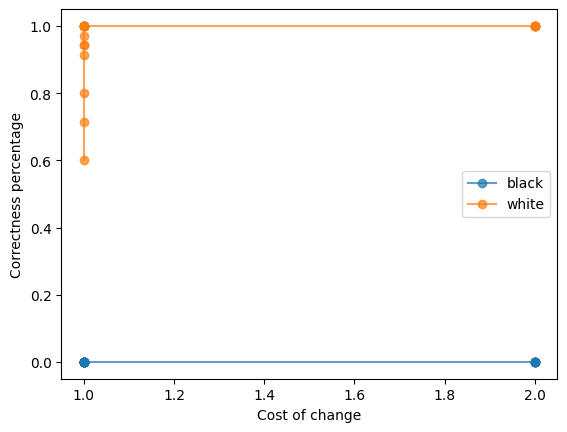

If gender = male, lsat = 33.0:
	Subgroup 'black', 1.53% covered out of 1279
		Make lsat = 39.0 with correctness 0.00%.
		Make lsat = 40.0 with correctness 0.00%.
		Make lsat = 42.0 with correctness 0.00%.
		Make lsat = 38.0 with correctness 0.00%.
		Make lsat = 37.0 with correctness 0.00%.
		Make lsat = 36.0 with correctness 0.00%.
		Make lsat = 41.0 with correctness 0.00%.
		Make gender = female, lsat = 39.0 with correctness 0.00%.
		Make gender = female, lsat = 40.0 with correctness 0.00%.
		Make gender = female, lsat = 38.0 with correctness 0.00%.
		Make lsat = 44.0 with correctness 0.00%.
		Make lsat = 35.0 with correctness 0.00%.
		Make lsat = 43.0 with correctness 0.00%.
		Make lsat = 45.0 with correctness 0.00%.
		Make gender = female, lsat = 36.0 with correctness 0.00%.
		Make gender = female, lsat = 43.0 with correctness 0.00%.
		Make gender = female, lsat = 44.0 with correctness 0.00%.
		Make lsat = 46.0 with correctness 0.00%.
		Make lsat = 47.0 with correctness 0.00%.
		Mak

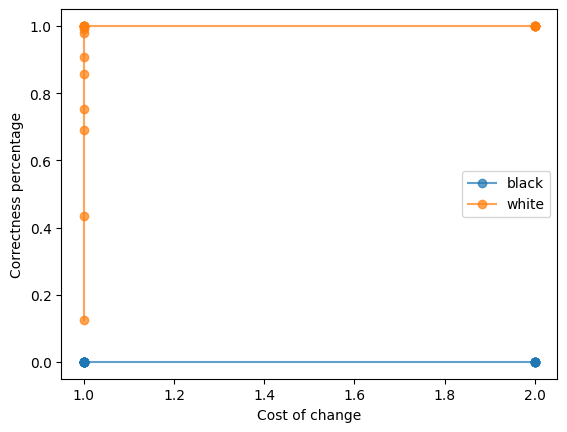

If gender = male, lsat = 27.0:
	Subgroup 'black', 1.28% covered out of 1279
		Make lsat = 39.0 with correctness 0.00%.
		Make lsat = 40.0 with correctness 0.00%.
		Make lsat = 42.0 with correctness 0.00%.
		Make lsat = 38.0 with correctness 0.00%.
		Make lsat = 37.0 with correctness 0.00%.
		Make lsat = 36.0 with correctness 0.00%.
		Make lsat = 41.0 with correctness 0.00%.
		Make gender = female, lsat = 39.0 with correctness 0.00%.
		Make gender = female, lsat = 40.0 with correctness 0.00%.
		Make gender = female, lsat = 38.0 with correctness 0.00%.
		Make lsat = 44.0 with correctness 0.00%.
		Make lsat = 35.0 with correctness 0.00%.
		Make lsat = 43.0 with correctness 0.00%.
		Make lsat = 45.0 with correctness 0.00%.
		Make gender = female, lsat = 36.0 with correctness 0.00%.
		Make gender = female, lsat = 43.0 with correctness 0.00%.
		Make gender = female, lsat = 44.0 with correctness 0.00%.
		Make lsat = 46.0 with correctness 0.00%.
		Make lsat = 47.0 with correctness 0.00%.
		Mak

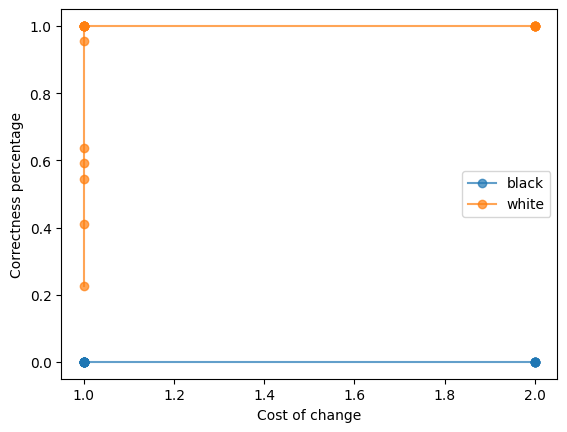

If gender = male, lsat = 30.0:
	Subgroup 'black', 3.32% covered out of 1279
		Make lsat = 39.0 with correctness 0.00%.
		Make lsat = 40.0 with correctness 0.00%.
		Make lsat = 42.0 with correctness 0.00%.
		Make lsat = 38.0 with correctness 0.00%.
		Make lsat = 37.0 with correctness 0.00%.
		Make lsat = 36.0 with correctness 0.00%.
		Make lsat = 41.0 with correctness 0.00%.
		Make gender = female, lsat = 39.0 with correctness 0.00%.
		Make gender = female, lsat = 40.0 with correctness 0.00%.
		Make gender = female, lsat = 38.0 with correctness 0.00%.
		Make lsat = 44.0 with correctness 0.00%.
		Make lsat = 35.0 with correctness 0.00%.
		Make lsat = 43.0 with correctness 0.00%.
		Make lsat = 45.0 with correctness 0.00%.
		Make gender = female, lsat = 36.0 with correctness 0.00%.
		Make gender = female, lsat = 43.0 with correctness 0.00%.
		Make gender = female, lsat = 44.0 with correctness 0.00%.
		Make lsat = 46.0 with correctness 0.00%.
		Make lsat = 47.0 with correctness 0.00%.
		Mak

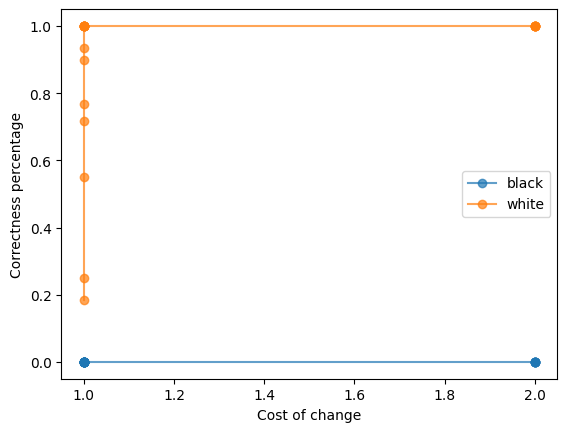

If gender = male, lsat = 32.0:
	Subgroup 'black', 4.34% covered out of 1279
		Make lsat = 39.0 with correctness 0.00%.
		Make lsat = 40.0 with correctness 0.00%.
		Make lsat = 42.0 with correctness 0.00%.
		Make lsat = 38.0 with correctness 0.00%.
		Make lsat = 37.0 with correctness 0.00%.
		Make lsat = 36.0 with correctness 0.00%.
		Make lsat = 41.0 with correctness 0.00%.
		Make gender = female, lsat = 39.0 with correctness 0.00%.
		Make gender = female, lsat = 40.0 with correctness 0.00%.
		Make gender = female, lsat = 38.0 with correctness 0.00%.
		Make lsat = 44.0 with correctness 0.00%.
		Make lsat = 35.0 with correctness 0.00%.
		Make lsat = 43.0 with correctness 0.00%.
		Make lsat = 45.0 with correctness 0.00%.
		Make gender = female, lsat = 36.0 with correctness 0.00%.
		Make gender = female, lsat = 43.0 with correctness 0.00%.
		Make gender = female, lsat = 44.0 with correctness 0.00%.
		Make lsat = 46.0 with correctness 0.00%.
		Make lsat = 47.0 with correctness 0.00%.
		Mak

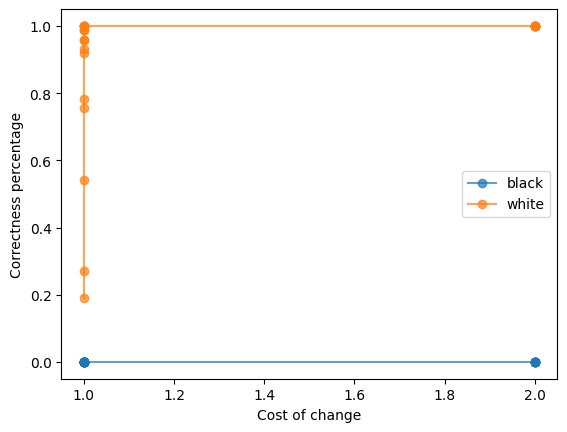

If gender = male, lsat = 34.0:
	Subgroup 'black', 2.04% covered out of 1279
		Make lsat = 39.0 with correctness -0.00%.
		Make lsat = 40.0 with correctness -0.00%.
		Make lsat = 42.0 with correctness -0.00%.
		Make lsat = 38.0 with correctness -0.00%.
		Make lsat = 37.0 with correctness -0.00%.
		Make lsat = 36.0 with correctness -0.00%.
		Make lsat = 41.0 with correctness -0.00%.
		Make gender = female, lsat = 39.0 with correctness -0.00%.
		Make gender = female, lsat = 40.0 with correctness -0.00%.
		Make gender = female, lsat = 38.0 with correctness -0.00%.
		Make lsat = 44.0 with correctness -0.00%.
		Make lsat = 35.0 with correctness -0.00%.
		Make lsat = 43.0 with correctness -0.00%.
		Make lsat = 45.0 with correctness -0.00%.
		Make gender = female, lsat = 36.0 with correctness -0.00%.
		Make gender = female, lsat = 43.0 with correctness -0.00%.
		Make gender = female, lsat = 44.0 with correctness -0.00%.
		Make lsat = 46.0 with correctness -0.00%.
		Make lsat = 47.0 with correc

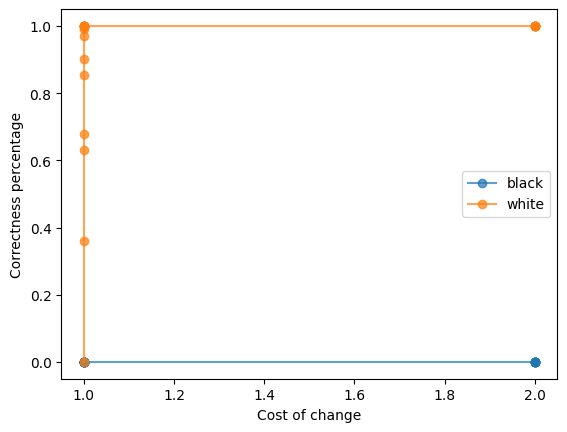

If ugpa = 2.5, gender = male:
	Subgroup 'black', 3.32% covered out of 1279
		Make ugpa = 3.2 with correctness 0.00%.
		Make ugpa = 3.5, gender = female with correctness 0.00%.
		Make ugpa = 3.4, gender = female with correctness 0.00%.
		Make ugpa = 3.7, gender = female with correctness 0.00%.
		Make ugpa = 3.8, gender = female with correctness 0.00%.
		Make ugpa = 3.2, gender = female with correctness 0.00%.
		Make ugpa = 3.1, gender = female with correctness 0.00%.
		Make ugpa = 2.6 with correctness 0.00%.
	Subgroup 'white', 2.84% covered out of 17921
		Make ugpa = 3.2 with correctness 50.00%.
		Make ugpa = 3.5, gender = female with correctness 63.04%.
		Make ugpa = 3.4, gender = female with correctness 50.00%.
		Make ugpa = 3.7, gender = female with correctness 73.91%.
		Make ugpa = 3.8, gender = female with correctness 80.43%.
		Make ugpa = 3.2, gender = female with correctness 39.13%.
		Make ugpa = 3.1, gender = female with correctness 28.26%.
		Make ugpa = 2.6 with correctness 15.

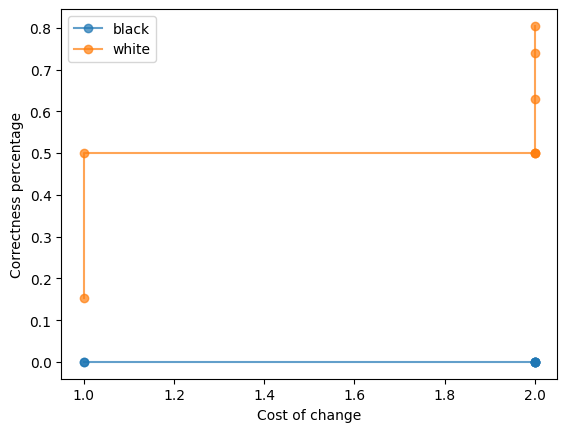

In [19]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="weighted-average",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10
)

cum_cors = gfacts.cumcorr_all(top_rules, X_test, model, sensitive_attribute=sensitive_attribute)

pop_sizes = {sg: (df[sensitive_attribute] == sg).sum() for sg in df[sensitive_attribute].unique()}
print_recourse_report(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors
)

Finally, save state, if you wish.

In [22]:
import dill

with open("stateLawSchool.data", "wb") as outf:
    dill.dump((rules_by_if, model, X_test), outf)